In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Transformer Encoder Block

## Objectif
Assembler tous les composants pour créer un bloc Transformer complet.

## Architecture du bloc Encoder:
```
Input
  ↓
Multi-Head Attention
  ↓
Add & Norm (Residual Connection + Layer Normalization)
  ↓
Feed-Forward Network
  ↓
Add & Norm
  ↓
Output
```

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

## 1. Composants nécessaires

### 1.1 Scaled Dot-Product Attention

In [5]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = scores + mask
    
    attention = F.softmax(scores, dim=-1)
    output = torch.matmul(attention, V)
    
    return output, attention

print("✓ Scaled Dot-Product Attention défini")

✓ Scaled Dot-Product Attention défini


### 1.2 Multi-Head Attention

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.qkv_layer = nn.Linear(d_model, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.size()
        
        qkv = self.qkv_layer(x)
        qkv = qkv.reshape(batch_size, seq_len, self.num_heads, 3 * self.d_k)
        qkv = qkv.permute(0, 2, 1, 3)
        Q, K, V = qkv.chunk(3, dim=-1)
        
        values, attention = scaled_dot_product_attention(Q, K, V, mask)
        values = values.permute(0, 2, 1, 3).reshape(batch_size, seq_len, d_model)
        output = self.linear_layer(values)
        
        return output, attention

print("✓ Multi-Head Attention défini")

✓ Multi-Head Attention défini


### 1.3 Layer Normalization

In [7]:
class LayerNormalization(nn.Module):
    def __init__(self, d_model, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        normalized = (x - mean) / (std + self.eps)
        return self.gamma * normalized + self.beta

print("✓ Layer Normalization défini")

✓ Layer Normalization défini


### 1.4 Position-wise Feed-Forward Network

In [8]:
class PositionWiseFeedForward(nn.Module):
    """
    FFN(x) = max(0, xW1 + b1)W2 + b2
    """
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # (batch, seq, d_model) -> (batch, seq, d_ff) -> (batch, seq, d_model)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

print("✓ Feed-Forward Network défini")

✓ Feed-Forward Network défini


### 1.5 Positional Encoding

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                            (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0)

print("✓ Positional Encoding défini")

✓ Positional Encoding défini


## 2. Bloc Encoder complet

In [10]:
class TransformerEncoderBlock(nn.Module):
    """
    Un bloc Transformer Encoder complet
    """
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        
        # Multi-Head Attention
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = LayerNormalization(d_model)
        
        # Feed-Forward
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = LayerNormalization(d_model)
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch_size, seq_len, d_model)
            mask: Optional attention mask
        """
        # 1. Multi-Head Attention + Residual + Norm
        attn_output, attention = self.attention(x, mask)
        x = x + self.dropout1(attn_output)  # Residual connection
        x = self.norm1(x)  # Layer normalization
        
        # 2. Feed-Forward + Residual + Norm
        ffn_output = self.ffn(x)
        x = x + self.dropout2(ffn_output)  # Residual connection
        x = self.norm2(x)  # Layer normalization
        
        return x, attention

print("✓ TransformerEncoderBlock complet défini")

✓ TransformerEncoderBlock complet défini


## 3. Test du bloc Encoder

In [11]:
# Paramètres
batch_size = 2
seq_len = 10
d_model = 512
num_heads = 8
d_ff = 2048

# Créer le bloc
encoder_block = TransformerEncoderBlock(d_model, num_heads, d_ff)

# Input (simulant des embeddings avec positional encoding)
x = torch.randn(batch_size, seq_len, d_model)

print(f"Input shape: {x.shape}")

# Forward pass
output, attention = encoder_block(x)

print(f"Output shape: {output.shape}")
print(f"Attention shape: {attention.shape}")
print(f"\n✓ Le bloc Encoder fonctionne correctement!")

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
Attention shape: torch.Size([2, 8, 10, 10])

✓ Le bloc Encoder fonctionne correctement!


## 4. Encoder complet (Stack de blocs)

In [12]:
class TransformerEncoder(nn.Module):
    """
    Transformer Encoder complet avec N blocs
    """
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, 
                 max_len=5000, dropout=0.1):
        super().__init__()
        
        # Token embedding
        self.embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        # Stack de N blocs encoders
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch_size, seq_len) - indices de tokens
            mask: Optional attention mask
        """
        # 1. Embedding + scaling
        x = self.embedding(x) * math.sqrt(self.d_model)
        
        # 2. Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # 3. Passer par tous les blocs encoder
        attentions = []
        for layer in self.layers:
            x, attention = layer(x, mask)
            attentions.append(attention)
        
        return x, attentions

print("✓ TransformerEncoder complet défini")

✓ TransformerEncoder complet défini


## 5. Test de l'Encoder complet

In [13]:
# Paramètres
vocab_size = 10000
d_model = 512
num_heads = 8
d_ff = 2048
num_layers = 6

# Créer l'encoder
encoder = TransformerEncoder(
    vocab_size=vocab_size,
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_layers=num_layers
)

# Input: indices de tokens
batch_size = 2
seq_len = 20
x = torch.randint(0, vocab_size, (batch_size, seq_len))

print(f"Input shape (token indices): {x.shape}")
print(f"Exemple d'input:\n{x[0][:10]}")

# Forward pass
output, attentions = encoder(x)

print(f"\nOutput shape: {output.shape}")
print(f"Number of attention maps: {len(attentions)}")
print(f"Each attention map shape: {attentions[0].shape}")
print(f"\n✓ L'Encoder Transformer complet fonctionne!")

# Compter les paramètres
total_params = sum(p.numel() for p in encoder.parameters())
print(f"\nNombre total de paramètres: {total_params:,}")

Input shape (token indices): torch.Size([2, 20])
Exemple d'input:
tensor([3404, 4310, 8438, 4041,  347,  102, 8537, 9471, 7171, 7034])

Output shape: torch.Size([2, 20, 512])
Number of attention maps: 6
Each attention map shape: torch.Size([2, 8, 20, 20])

✓ L'Encoder Transformer complet fonctionne!

Nombre total de paramètres: 24,034,304


## 6. Visualisation des poids d'attention par couche

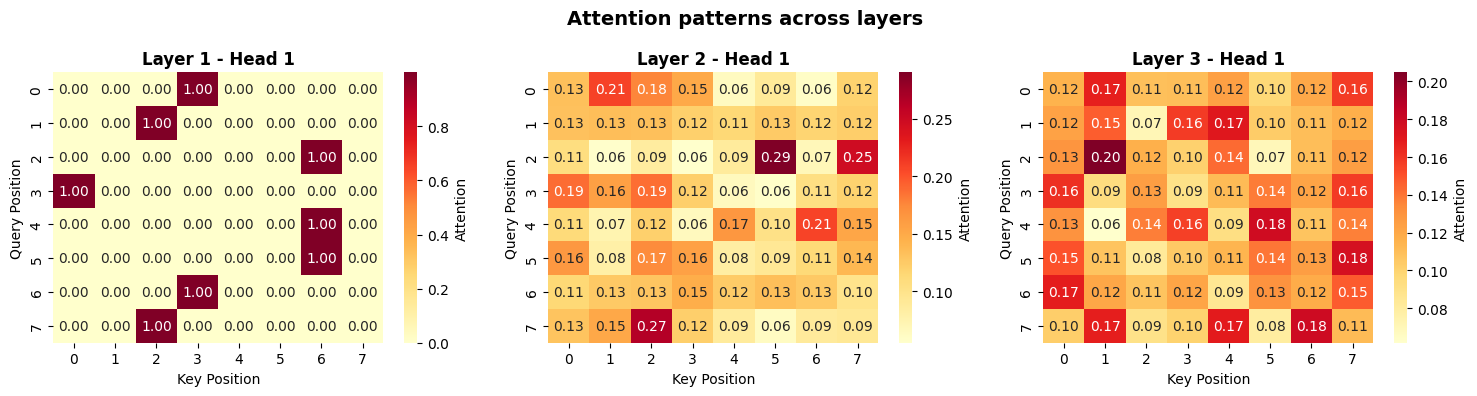


Observation: Les couches supérieures capturent des patterns plus abstraits!


In [14]:
# Petit exemple pour visualisation
small_encoder = TransformerEncoder(
    vocab_size=100,
    d_model=64,
    num_heads=4,
    d_ff=256,
    num_layers=3
)

# Phrase courte
x_viz = torch.randint(0, 100, (1, 8))
_, attentions_viz = small_encoder(x_viz)

# Visualiser la première tête de chaque couche
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, ax in enumerate(axes):
    attn = attentions_viz[i][0, 0].detach().numpy()  # Batch 0, Head 0
    sns.heatmap(attn, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax,
                cbar_kws={'label': 'Attention'})
    ax.set_title(f'Layer {i+1} - Head 1', fontweight='bold')
    ax.set_xlabel('Key Position')
    ax.set_ylabel('Query Position')

plt.suptitle('Attention patterns across layers', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservation: Les couches supérieures capturent des patterns plus abstraits!")

## 7. Analyse du flot d'information

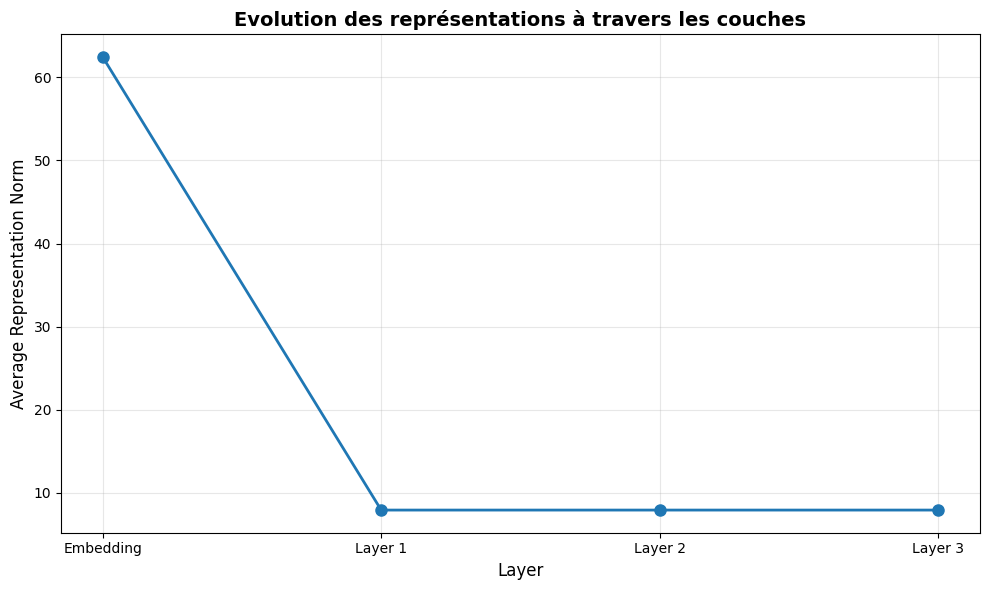

Les représentations sont normalisées à chaque couche (Layer Norm)


In [15]:
# Tracer l'évolution des représentations à travers les couches
def analyze_representations(encoder, x):
    """
    Analyse comment les représentations évoluent couche par couche
    """
    with torch.no_grad():
        # Embedding
        h = encoder.embedding(x) * math.sqrt(encoder.d_model)
        h = encoder.pos_encoding(h)
        
        norms = [h.norm(dim=-1).mean().item()]
        
        # Passer par chaque couche
        for layer in encoder.layers:
            h, _ = layer(h)
            norms.append(h.norm(dim=-1).mean().item())
    
    return norms

x_test = torch.randint(0, 100, (1, 10))
norms = analyze_representations(small_encoder, x_test)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(norms)), norms, marker='o', linewidth=2, markersize=8)
plt.xlabel('Layer', fontsize=12)
plt.ylabel('Average Representation Norm', fontsize=12)
plt.title('Evolution des représentations à travers les couches', 
          fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(range(len(norms)), ['Embedding'] + [f'Layer {i+1}' for i in range(len(norms)-1)])
plt.tight_layout()
plt.show()

print("Les représentations sont normalisées à chaque couche (Layer Norm)")

## 8. Exemple concret: Classification de sentiment

In [16]:
class SentimentClassifier(nn.Module):
    """
    Classificateur de sentiment utilisant un Transformer Encoder
    """
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, num_classes=2):
        super().__init__()
        
        self.encoder = TransformerEncoder(
            vocab_size, d_model, num_heads, d_ff, num_layers
        )
        
        # Classification head
        self.classifier = nn.Linear(d_model, num_classes)
    
    def forward(self, x):
        # Encoder
        encoded, _ = self.encoder(x)
        
        # Pool: prendre la moyenne sur la séquence
        pooled = encoded.mean(dim=1)
        
        # Classification
        logits = self.classifier(pooled)
        
        return logits

# Test
sentiment_model = SentimentClassifier(
    vocab_size=10000,
    d_model=128,
    num_heads=4,
    d_ff=512,
    num_layers=2,
    num_classes=2  # Positive/Negative
)

# Phrases d'exemple (simulées avec des indices)
sentences = torch.randint(0, 10000, (4, 15))  # 4 phrases de 15 mots
predictions = sentiment_model(sentences)

print(f"Input shape: {sentences.shape}")
print(f"Output shape: {predictions.shape}")
print(f"\nPredictions (logits):")
print(predictions)
print(f"\nClasses prédites: {predictions.argmax(dim=1)}")
print(f"\n✓ Le modèle peut faire des prédictions!")

Input shape: torch.Size([4, 15])
Output shape: torch.Size([4, 2])

Predictions (logits):
tensor([[ 0.1299, -0.4146],
        [-0.0680, -0.0553],
        [-0.1368, -0.3942],
        [ 0.2307, -0.1503]], grad_fn=<AddmmBackward0>)

Classes prédites: tensor([0, 1, 0, 0])

✓ Le modèle peut faire des prédictions!


## Résumé

### Architecture complète d'un Transformer Encoder:

```
Input Tokens
     ↓
Token Embedding × √d_model
     ↓
+ Positional Encoding
     ↓
┌─────────────────────────┐
│  Encoder Block 1        │
│  • Multi-Head Attention │
│  • Add & Norm          │
│  • Feed-Forward        │
│  • Add & Norm          │
└─────────────────────────┘
     ↓
┌─────────────────────────┐
│  Encoder Block 2        │
│        ...              │
└─────────────────────────┘
     ↓
     ...
     ↓
┌─────────────────────────┐
│  Encoder Block N        │
└─────────────────────────┘
     ↓
Output Representations
```

### Composants clés:

1. **Multi-Head Attention**: Capture les relations entre tokens
2. **Residual Connections**: Facilite le gradient flow
3. **Layer Normalization**: Stabilise l'entraînement
4. **Feed-Forward Network**: Transformations non-linéaires
5. **Positional Encoding**: Ajoute l'information de position

### Paramètres typiques:

| Modèle | Layers | d_model | Heads | Parameters |
|--------|--------|---------|-------|------------|
| BERT-base | 12 | 768 | 12 | 110M |
| BERT-large | 24 | 1024 | 16 | 340M |
| GPT-2 | 12 | 768 | 12 | 117M |
| GPT-3 | 96 | 12288 | 96 | 175B |

### Applications:
- Classification de texte
- Question Answering
- Named Entity Recognition
- Encodage de texte pour d'autres tâches